# 유수분 밸런스 EDA


In [59]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pandas as pd
import sys

In [60]:
#시각화 패키지들
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
%matplotlib inline

plt.style.use("ggplot")

In [61]:
#분석 관련
from scipy.stats import chi2_contingency
from scipy.stats import kstest
from statsmodels.formula.api import ols

In [62]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [63]:
import pickle

# 파일 불러오기
train = pd.read_pickle('./data/train_nona.pkl')
#train = pd.read_excel('./data/train_nona.xlsx')
#submission = pd.read_csv('./data/sample_submission.csv')

In [64]:
train.head()

,측정기기,"시,도",년,월,일,시,시간대,연령,연령대,성별,피부타입,수분,유분,탄력,평균 기온,강수량,평균 풍속,평균 습도,일조합,미세먼지
0,스킨터치1,광주광역시,2014,3,29,19,저녁,21.0,20.0,여자,4.0,99.0,32,92.0,8.6,101.7,2.0,61.0,213.4,49.0
1,스킨터치1,서울특별시,2012,12,29,20,저녁,22.0,20.0,여자,6.0,99.0,87,92.0,-4.1,41.4,2.7,57.0,193.6,41.0
2,스킨터치1,서울특별시,2013,12,18,20,저녁,22.0,20.0,여자,3.0,99.0,6,92.0,-0.2,24.7,2.4,60.0,184.4,55.0
3,스킨터치1,부산광역시,2013,8,31,15,오후,22.0,20.0,여자,4.0,99.0,40,92.0,28.0,144.5,3.3,67.0,286.5,47.0
4,스킨터치1,부산광역시,2012,7,29,18,저녁,23.0,20.0,여자,4.0,99.0,46,92.0,25.5,502.0,3.3,78.0,221.4,40.0


# 수분 데이터 확인

In [65]:
train['수분'].describe()

count    513528.000000
mean         46.910665
std          16.079374
min           1.000000
25%          38.000000
50%          45.000000
75%          54.000000
max          99.000000
Name: 수분, dtype: float64

최대 99, 최소 1로 유수분 비율을 구하는데는 문제 없다.

# 유분 데이터 확인

In [66]:
train['유분'].describe()

count    513528.000000
mean         41.941285
std          32.161210
min           0.000000
25%          14.000000
50%          36.000000
75%          65.000000
max          99.000000
Name: 유분, dtype: float64

최소값 0으로, 유분만 분모에 들어가면 안된다.

그래서, 수분+유분을 분모로

# 유수분 밸런스 컬럼 제작

In [67]:
train['유수분'] = train['유분']/(train['수분']+train['유분'])
train.head()

,측정기기,"시,도",년,월,일,시,시간대,연령,연령대,성별,...,수분,유분,탄력,평균 기온,강수량,평균 풍속,평균 습도,일조합,미세먼지,유수분
0,스킨터치1,광주광역시,2014,3,29,19,저녁,21.0,20.0,여자,...,99.0,32,92.0,8.6,101.7,2.0,61.0,213.4,49.0,0.244275
1,스킨터치1,서울특별시,2012,12,29,20,저녁,22.0,20.0,여자,...,99.0,87,92.0,-4.1,41.4,2.7,57.0,193.6,41.0,0.467742
2,스킨터치1,서울특별시,2013,12,18,20,저녁,22.0,20.0,여자,...,99.0,6,92.0,-0.2,24.7,2.4,60.0,184.4,55.0,0.057143
3,스킨터치1,부산광역시,2013,8,31,15,오후,22.0,20.0,여자,...,99.0,40,92.0,28.0,144.5,3.3,67.0,286.5,47.0,0.287770
4,스킨터치1,부산광역시,2012,7,29,18,저녁,23.0,20.0,여자,...,99.0,46,92.0,25.5,502.0,3.3,78.0,221.4,40.0,0.317241


# 탄력 시각화

- 유수분, 탄력 시각화를 위해서 탄력이 범주화가 가능한지 확인

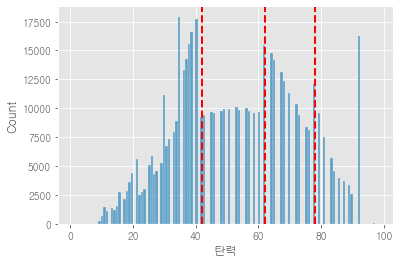

In [68]:
sns.histplot(train['탄력'])
plt.axvline(x=42, color='r', linestyle='--', linewidth=2)
plt.axvline(x=62, color='r', linestyle='--', linewidth=2)
plt.axvline(x=78, color='r', linestyle='--', linewidth=2)


- 42 이하 D
- 62 이하 C
- 78 이하 B
- 그 이상 A

총 4개의 범주로 나눠서 시각화

In [69]:
train['탄력_bin']=pd.cut(train['탄력'],bins=[0,42,62,78,100],labels=['D','C','B','A'])

In [70]:
train['탄력_bin']

0         A
1         A
2         A
3         A
4         A
         ..
553043    D
553044    D
553045    D
553046    D
553047    D
Name: 탄력_bin, Length: 513528, dtype: category
Categories (4, object): ['D' < 'C' < 'B' < 'A']

<AxesSubplot:xlabel='탄력_bin', ylabel='Count'>

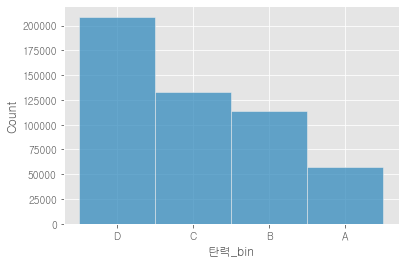

In [71]:
sns.histplot(train['탄력_bin'])

In [72]:
train['탄력_bin'].value_counts().to_frame().style.background_gradient(cmap='summer')

,탄력_bin
D,208951
C,132980
B,114189
A,57408


#  유수분, 탄력 시각화

## 유수분 일변량

<AxesSubplot:xlabel='유수분', ylabel='Count'>

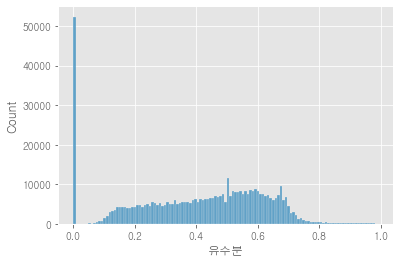

In [73]:
sns.histplot(train['유수분'])

In [74]:
train['유수분'].describe()

count    513528.000000
mean          0.407214
std           0.214786
min           0.000000
25%           0.250000
50%           0.442857
75%           0.579832
max           0.990000
Name: 유수분, dtype: float64

최대 비율 0.99, 최소 0

최소 점에 위치한 경우가 제일 많다.(유분이 0 인 경우)

0.3정도가 최적일것이라고 가설을 설정함.

## 유수분 이변량

### 탄력 범주를 통한 시각화

<AxesSubplot:xlabel='유수분', ylabel='Count'>

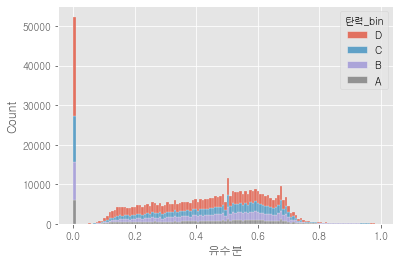

In [81]:
sns.histplot(x=train['유수분'],hue=train['탄력_bin'],multiple='stack')

예상과 달리 골고루 탄력이 분포한다...

<AxesSubplot:xlabel='유수분', ylabel='탄력_bin'>

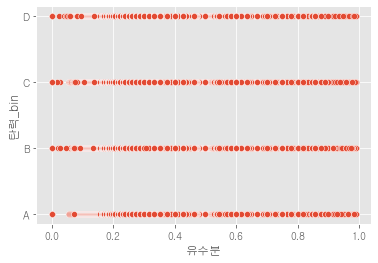

In [84]:
sns.scatterplot(x=train['유수분'],y=train['탄력_bin'])

In [85]:
train[['유수분','유분','수분','탄력']].corr()

,유수분,유분,수분,탄력
유수분,1.000000,0.863979,-0.060420,0.090076
유분,0.863979,1.000000,0.269872,0.072333
수분,-0.060420,0.269872,1.000000,-0.026374
탄력,0.090076,0.072333,-0.026374,1.000000


탄력과 유수분이 0.09 밖에 상관성이 없다.

나머지 변수도 상관성이 없게 관측된다.

피부의 건강도를 측정할 다른 변수가 필요한 것으로 생각된다.

# 결론

- 유수분 밸런스가 탄력을 설명해주지는 못한다.
- 탄력외의 다른 변수를 찾아야할지.
- 또는 유수분 밸런스 공식을 새로 생각해봐야 할지.